# MBML Project

The project explores the application of Variational Autoencoders (VAEs) and their extensions for classification tasks, particularly in scenarios with limited labeled data. The key aspects of the project are:

1. Supervised VAE with classifier addition:
It implements a standard VAE in Pyro and then adds a multiclass linear classifier on top of the latent space to perform supervised classification. This allows comparing classification performance using the learned latent representation.

2. Semi-Supervised VAE (ssVAE):
It extends the VAE to a semi-supervised setting, enabling the model to learn from both labeled and unlabeled data. The ssVAE reconstructs input data and predicts labels, aiming to improve classification accuracy when only a fraction of the data is labeled.

3. Active Learning with Entropy-based Sampling:
It employs an active learning strategy to select the most informative (high entropy) unlabeled data points for labeling. This aims to further enhance the model's performance by focusing on data points that the model is most uncertain about.

In [51]:
import numpy as np
import torch
import torch.nn as nn
from mnist_cached import MNISTCached as MNIST
from mnist_cached import setup_data_loaders
from vae_plots import mnist_test_tsne, plot_llk, plot_vae_samples

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.poutine as poutine
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)


In [2]:
torch.manual_seed(1234)
np.random.seed(1234)

## Variational Autoencoders in Pyro

We will now implement a VAE in Pyro. Let us begin by recapping the model introduced in the class. The generative process can be summarize as follows:

1. For each observation $n \in \{1,\dots,N\}$
    1. Sample latent projection $\textbf{z}_n \sim \mathcal{N}(\textbf{z}_n|\textbf{0}, \textbf{I})$
    2. Sample observation $\textbf{x}_n \sim \mathcal{N}(\textbf{x}_n|f_{\boldsymbol\theta}(\textbf{z}_n))$

Note that the neural network $f$ is outputting both the mean and variance of the Gaussian. 

Our goal is to compute the posterior distribution over the latent variables $\textbf{z}_n$, while jointly finding point estimates for the parameters of that neural network $\boldsymbol\theta$. Note that you could also treat $\boldsymbol\theta$ as latent variables and perform inference on them as well (i.e. a Bayesian neural network), but, for this particular model, point estimates are usually sufficient. 

We will also need an approximate distribution $q(\textbf{z})$ for VI. As we saw in the slides, we will use a second neural network $g$ to parameterize this variational distribution $q$. Therefore, we can represent the entire process of the training a VAE as follows:

<img style="width:50%" src="http://mlsm.man.dtu.dk/vae.png">

In the diagram, $g$ is the encoder network and $f$ is the decoder network. Lets begin by implementing those two neural networks in Torch:

In [3]:
# define the PyTorch module that parameterizes the
# diagonal gaussian distribution q(z|x)
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, input_dim):
        self.input_dim = input_dim
        super().__init__()
        # setup the three linear transformations used
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
        # first shape the mini-batch to have pixels in the rightmost dimension
        x = x.reshape(-1, self.input_dim)
        # then compute the hidden units
        hidden = self.softplus(self.fc1(x))
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


# define the PyTorch module that parameterizes the
# observation likelihood p(x|z)
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim, binary=False):
        self.binary = binary
        super().__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, output_dim)
        if not self.binary:
            self.fc22 = nn.Linear(hidden_dim, output_dim)
        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x input_dim
        if self.binary:
            out = torch.sigmoid(self.fc21(hidden))
        else:
            out = (self.fc21(hidden), self.softplus(self.fc22(hidden)))
        return out

In [52]:
def training_run(svi, epoch, epoch_loss, train_elbo, test_elbo, train_loader, test_loader, accuracy=None, rec_accuracy=None, y_label=False, use_cuda=False):
    if epoch % 5 == 0:
        # report training diagnostics
        normalizer_train = len(train_loader.dataset)
        total_epoch_loss_train = epoch_loss / normalizer_train
        train_elbo[epoch] = total_epoch_loss_train
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))
        if accuracy is not None:
            print("             average accuracy: %.4f" % (accuracy[-1]))
        if rec_accuracy is not None:
            print("             average reconstruction accuracy: %.4f" % (rec_accuracy[-1]))
        
        # initialize loss accumulator
        test_loss = 0.0
        # compute the loss over the entire test set
        for i, (x, y) in enumerate(test_loader):
            y = np.argmax(y, axis=1)
            # if on GPU put mini-batch into CUDA memory
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
            if y_label:
                # compute ELBO estimate and accumulate loss
                test_loss += svi.evaluate_loss(x, y)
            else:
                test_loss += svi.evaluate_loss(x)

        # report test diagnostics
        normalizer_test = len(test_loader.dataset)
    
        total_epoch_loss_test = test_loss / normalizer_test
        test_elbo[epoch] = total_epoch_loss_test
        print("[epoch %03d]  average test loss: %.4f" % (epoch, total_epoch_loss_test))
        plot_llk(train_elbo, test_elbo)

# 1. Supervised VAE with classifier addition

In [22]:

# define a PyTorch module for the VAE
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, input_dim=784, binary=False, use_cuda=False):
        self.input_dim = input_dim
        self.binary = binary
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim, binary=binary)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)

        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros(x.shape[0], self.z_dim)
            z_scale = torch.ones(x.shape[0], self.z_dim)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            img = self.decoder.forward(z)
            if self.binary:
                # sample from the Bernoulli distribution
                pyro.sample("obs", dist.Bernoulli(img, validate_args=False).to_event(1), obs=x.reshape(-1, self.input_dim))
            else:
                # sample from the Gaussian distribution
                loc, scale = img
                pyro.sample("obs", dist.Normal(loc, scale, validate_args=False).to_event(1), obs=x.reshape(-1, self.input_dim))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder.forward(x)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))


    # define a helper function for reconstructing images (this will useful later - ignore for now)
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
    
    def recontruct_accuracy(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        recon = self.decoder(z)
        recon_bin = (recon > 0.5).float()
        x_bin = (x > 0.5).float()
        accuracy = (recon_bin == x_bin).float().mean().item()
        return accuracy

### 1) Training VAE

In [23]:
use_cuda = False

# clear param store
pyro.clear_param_store()

num_classes = 10
loaders = setup_data_loaders(MNIST, use_cuda=False, batch_size=250, sup_num=49000)
train_loader = loaders["sup"]
test_loader = loaders["test"]

In [25]:
# setup the VAE
vae = VAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

# setup the optimizer
adam_args = {"lr": 1.0e-3}
optimizer = Adam(adam_args)

# setup the inference algorithm
elbo = Trace_ELBO()
svi = SVI(vae.model, vae.guide, optimizer, loss=elbo)

train_elbo = {}
test_elbo = {}
# training loop
num_epochs = 30
for epoch in range(num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, _ in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)
    training_run(svi, epoch, epoch_loss, train_elbo, test_elbo, train_loader, test_loader, y_label=False, use_cuda=False)

[epoch 000]  average training loss: 222.0383
[epoch 000]  average test loss: 241.9618
[epoch 005]  average training loss: 191.3540
[epoch 005]  average test loss: 194.5046
[epoch 010]  average training loss: 167.9827
[epoch 010]  average test loss: 172.1174
[epoch 015]  average training loss: 142.3824
[epoch 015]  average test loss: 145.3705
[epoch 020]  average training loss: 127.9428
[epoch 020]  average test loss: 131.4405
[epoch 025]  average training loss: 119.9676
[epoch 025]  average test loss: 123.0546


In [13]:
mnist_test_tsne(vae=vae, test_loader=test_loader)

/Users/techen/biosustain/course/model based machine learning/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/Users/techen/biosustain/course/model based machine learning/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### 2) Define a Pyro model and guide for a multiclass linear classifier

We will create a K-class linear model y ∼ Categorical(logits = z_loc @ W + b).  

In [26]:
num_classes = 10 # as we have 10 digits in MNIST

def classifier_model(x, obs=None):
    z = vae.encoder(x)[0]
    alpha = pyro.sample("alpha_c", pyro.distributions.Normal(0., 1.).expand( [num_classes]).to_event())
    beta = pyro.sample("beta_c", pyro.distributions.Normal(0., 1.).expand([z.shape[1], num_classes]).to_event())
    logits = z @ beta + alpha
    with pyro.plate("data", z.shape[0]):
        y = pyro.sample("y", pyro.distributions.Categorical(logits=logits), obs=obs)

### 3) Train the classifier in Pyro using SVI

You can run standard Pyro SVI over these model/guide definitions.

In [27]:
# Clear out any existing parameter values
# pyro.clear_param_store()

classifier_guide = AutoMultivariateNormal(classifier_model)

optimizer = Adam({"lr": 1.0e-3})
# Setup SVI
svi_classifier = SVI(
    model=classifier_model,
    guide=classifier_guide,
    optim=optimizer,
    loss=Trace_ELBO(num_particles=3),
)
num_steps = 100  # Adjust as needed
for step in range(num_steps):
    epoch_loss = 0.0
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        y = np.argmax(y, axis=1) 
        # do ELBO gradient and accumulate loss
        epoch_loss += svi_classifier.step(x, y)
    if step % 5 == 0:
        print(f"[step {step}] loss = {epoch_loss:.2f}")


[step 0] loss = 326483.54
[step 5] loss = 189551.75
[step 10] loss = 135511.57
[step 15] loss = 108780.53
[step 20] loss = 97038.09
[step 25] loss = 89934.24
[step 30] loss = 86448.65
[step 35] loss = 83887.76
[step 40] loss = 80822.24
[step 45] loss = 81354.74
[step 50] loss = 79873.90
[step 55] loss = 79517.23
[step 60] loss = 78289.18
[step 65] loss = 78574.13
[step 70] loss = 77581.79
[step 75] loss = 77361.35
[step 80] loss = 77448.35
[step 85] loss = 77041.87
[step 90] loss = 77983.79
[step 95] loss = 77447.15


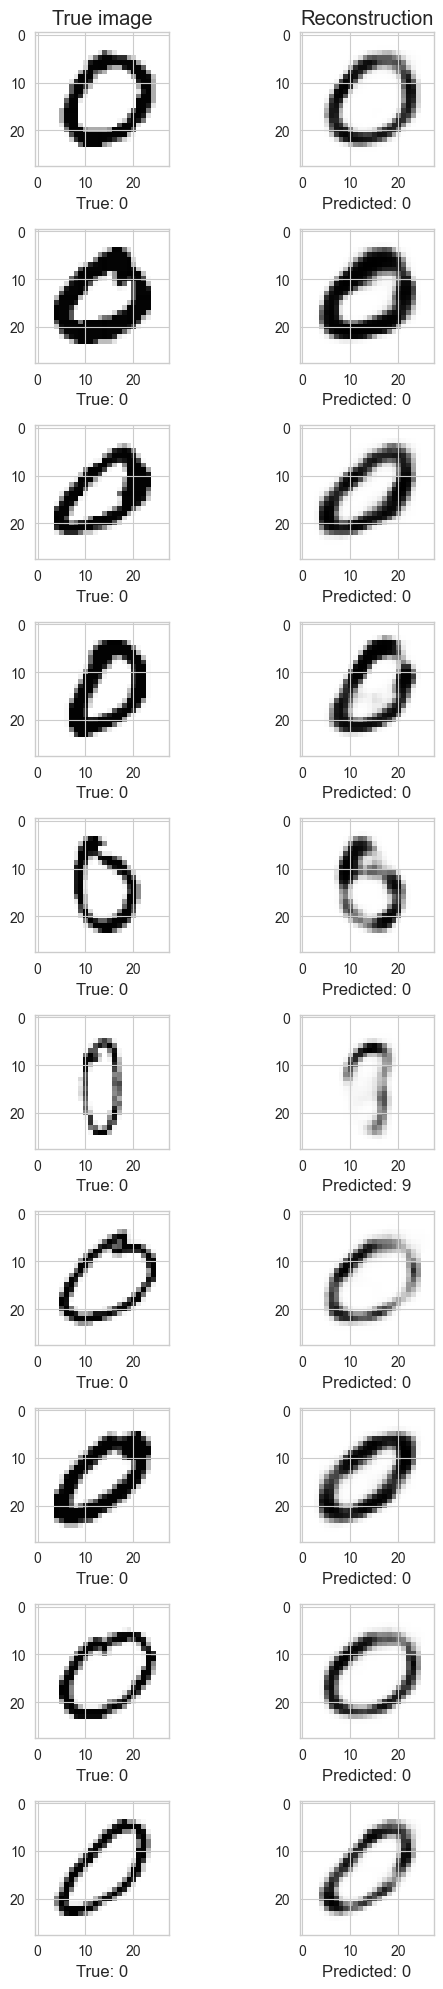

Classification accuracy on these 10 samples: 0.90


In [42]:
# pick 10 random test images from the first mini-batch and visualize how well we're reconstructing them
fig, axs = plt.subplots(10, 2, figsize=(6, 20))
x, y = next(iter(train_loader)) 
if use_cuda:
    x = x.cuda()
    y = y.cuda()

true_labels = torch.argmax(y, dim=1)

reco_indices = np.random.randint(0, x.shape[0], 10)

# Get predictions for the selected images
with torch.no_grad():
    # Get the latent representations
    z = vae.encoder(x[reco_indices])[0]
    loc_param = pyro.param("AutoMultivariateNormal.loc")
    alpha = loc_param[:num_classes]
    beta = loc_param[num_classes:].reshape(vae.z_dim, num_classes)
    
    # Compute logits for classification
    logits = z @ beta + alpha
    predicted_labels = torch.argmax(logits, dim=1)

# Plot the images and reconstructions
for i in range(10):
    index = reco_indices[i]
    test_img = x[index, :]
    reco_img = vae.reconstruct_img(test_img)
    
    axs[i, 0].imshow(test_img.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
    axs[i, 1].imshow(reco_img.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
    
    # Add labels
    axs[i, 0].set_xlabel(f"True: {true_labels[index].item()}")
    axs[i, 1].set_xlabel(f"Predicted: {predicted_labels[i].item()}")

axs[0, 0].set_title("True image")
axs[0, 1].set_title("Reconstruction")

plt.tight_layout()
plt.show()

# Print accuracy on these 10 samples
accuracy = (predicted_labels == true_labels[reco_indices]).float().mean().item()
print(f"Classification accuracy on these 10 samples: {accuracy:.2f}")

# 2. Semi Supervised VAE
- The model takes partially labelled MINST data from each batch and the model reconstruct and predict the number separately.



### 1) Definition of Semi Supervised VAE

In [43]:

# define a PyTorch module for the VAE
class ssVAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, input_dim=784, binary=False, use_cuda=False):
        self.input_dim = input_dim
        self.binary = binary
        super().__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim, input_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim, binary=binary)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x, y=None, fraction=1.0):
        BATCH_SIZE = x.shape[0]
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        alpha = pyro.sample("alpha", pyro.distributions.Normal(0., 1.).expand([num_classes]).to_event(1))
        beta = pyro.sample("beta", pyro.distributions.Normal(0., 1.).expand([self.z_dim, num_classes]).to_event(2))
        with pyro.plate("data", x.shape[0]):
            z_loc = torch.zeros(x.shape[0], self.z_dim)
            z_scale = torch.ones(x.shape[0], self.z_dim)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))
            # Prepare for classification
            logits =   z @ beta + alpha
            # Reconstruct image
            img = self.decoder.forward(z)

            # Sample from the observation likelihood
            if self.binary:
                # sample from the Bernoulli distribution
                pyro.sample("obs", dist.Bernoulli(img, validate_args=False).to_event(1), obs=x.reshape(-1, self.input_dim))
                is_labelled = (y != -1)
                y[~is_labelled] = 0
                with poutine.mask(mask=is_labelled):
                    with pyro.poutine.scale(scale=1/fraction):
                        pyro.sample("y", dist.Categorical(logits=logits), obs=y, infer={'is_auxiliary': True})

    def guide(self, x, y=None, fraction=None):
        # register PyTorch modules with Pyro
        pyro.module("encoder", self.encoder)

        # approximate posterior over alpha and beta
        alpha_loc = pyro.param("alpha_loc", torch.zeros(num_classes))
        alpha_scale = pyro.param("alpha_scale", torch.ones(num_classes))
        pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale).to_event(1))

        beta_loc = pyro.param("beta_loc", torch.zeros(self.z_dim, num_classes))
        beta_scale = pyro.param("beta_scale", torch.ones(self.z_dim, num_classes))
        beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale).to_event(2))
        
        with pyro.plate("data", x.shape[0]):
            # approximate posterior over z
            z_loc, z_scale = self.encoder.forward(x)
            z = pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

            
            # for unlabeled data, sample y from the classifier
            if y is not None:
                mask_unlabelled = (y == -1)
                if torch.any(mask_unlabelled):
                    logits = z @ beta + alpha_loc
                    with poutine.mask(mask=mask_unlabelled):
                        pyro.sample("y", dist.Categorical(logits=logits),infer={'is_auxiliary': True})
                
    def classifier(self, x):
        z_loc, z_scale = self.encoder(x)
        z = z_loc
        alpha_loc = pyro.param("alpha_loc")
        beta_loc = pyro.param("beta_loc")
        logits = z @ beta_loc + alpha_loc
        return torch.argmax(logits, dim=1)

    # define a helper function for reconstructing images (this will useful later - ignore for now)
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img
    
    def recontruct_accuracy(self, x):
        z_loc, z_scale = self.encoder(x)
        z = dist.Normal(z_loc, z_scale).sample()
        recon = self.decoder(z)
        recon_bin = (recon > 0.5).float()
        x_bin = (x > 0.5).float()
        accuracy = (recon_bin == x_bin).float().mean().item()
        return accuracy

    def accuracy(self, x, y):
        # encode image x
        z, _ = self.encoder(x)
        alpha_loc = pyro.param("alpha_loc")
        beta_loc = pyro.param("beta_loc")
        logits = z @ beta_loc + alpha_loc

        y_pred = torch.argmax(logits, dim=1)
        accuracy = (y == y_pred).float().mean().item()
        return accuracy

### 2) Training Supervised VAE with Classifier

In [53]:

pyro.clear_param_store()

# setup the VAE
ssvae = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

# setup the optimizer
adam_args = {"lr": 1.0e-3}
optimizer = Adam(adam_args)

# setup the inference algorithm
elbo = Trace_ELBO()
svi = SVI(ssvae.model, ssvae.guide, optimizer, loss=elbo)

train_elbo = {}
test_elbo = {}

accuracy = []
rec_accuracy = []

# training loop
num_epochs = 30
for epoch in range(num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.0
    epoch_acc = []
    epoch_rec_acc = []
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        y = np.argmax(y, axis=1)
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x, y)
        epoch_acc.append(ssvae.accuracy(x, y))
        epoch_rec_acc.append(ssvae.recontruct_accuracy(x))

    # Store average accuracy for this epoch
    accuracy.append(np.mean(epoch_acc))
    rec_accuracy.append(np.mean(epoch_rec_acc))

    training_run(svi, epoch, epoch_loss, train_elbo, test_elbo, train_loader, test_loader, accuracy=accuracy, rec_accuracy=rec_accuracy, y_label=True, use_cuda=use_cuda)


[epoch 000]  average training loss: 234.3851
             average accuracy: 0.2358
             average reconstruction accuracy: 0.8756
[epoch 000]  average test loss: 255.2311
[epoch 005]  average training loss: 203.5946
             average accuracy: 0.2555
             average reconstruction accuracy: 0.8848
[epoch 005]  average test loss: 209.1225
[epoch 010]  average training loss: 181.7430
             average accuracy: 0.4588
             average reconstruction accuracy: 0.9016
[epoch 010]  average test loss: 185.1393
[epoch 015]  average training loss: 156.4482
             average accuracy: 0.7339
             average reconstruction accuracy: 0.9216
[epoch 015]  average test loss: 158.3919
[epoch 020]  average training loss: 137.7967
             average accuracy: 0.8212
             average reconstruction accuracy: 0.9376
[epoch 020]  average test loss: 142.6834
[epoch 025]  average training loss: 127.9205
             average accuracy: 0.8807
             average reconstruct

### 3) Train Semi-supervised VAE with classifier

In [65]:
def ss_loader(y, ss_fraction):    
    shape = y.shape
    N = len(y)
    # Number of labels to mask
    L1 = int(N * (1-ss_fraction))
    y_masked = y.clone()
    indices = torch.randperm(N)[:L1]
    
    # Set the selected indices to -1
    y_masked[indices] = -1
    
    # Return the tensor and the list of indices that were masked
    return y_masked.reshape(shape), indices.tolist()

In [68]:

pyro.clear_param_store()

# setup the VAE
ssvae = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

# setup the optimizer
adam_args = {"lr": 1.0e-3}
optimizer = Adam(adam_args)

# setup the inference algorithm
elbo = Trace_ELBO()
svi = SVI(ssvae.model, ssvae.guide, optimizer, loss=elbo)

train_elbo = {}
test_elbo = {}
# training loop
num_epochs = 30
fraction = 0.5

for epoch in range(num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader

    idxs_unsup = []
    for x, y in train_loader:
        # if on GPU put mini-batch into CUDA memory
        y = np.argmax(y, axis=1)
        y, idx_unsup = ss_loader(y, fraction)
        idxs_unsup.append(idx_unsup)
        if use_cuda:
            x = x.cuda()
            y = y.cuda()

        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x, y, fraction=fraction)
    
    if epoch % 5 == 0:
        training_run(svi, epoch, epoch_loss, train_elbo, test_elbo, train_loader, test_loader, y_label=True, use_cuda=use_cuda)

[epoch 000]  average training loss: 259.4761
[epoch 000]  average test loss: 263.7577
[epoch 005]  average training loss: 216.9215
[epoch 005]  average test loss: 221.2093
[epoch 010]  average training loss: 207.8380
[epoch 010]  average test loss: 210.3334
[epoch 015]  average training loss: 195.2713
[epoch 015]  average test loss: 195.7529
[epoch 020]  average training loss: 186.9580
[epoch 020]  average test loss: 187.9957
[epoch 025]  average training loss: 177.0825
[epoch 025]  average test loss: 178.5219


### 3) Reconstruction of the image compare to original and supervised model

Text(0.5, 1.0, 'Pred/True Label')

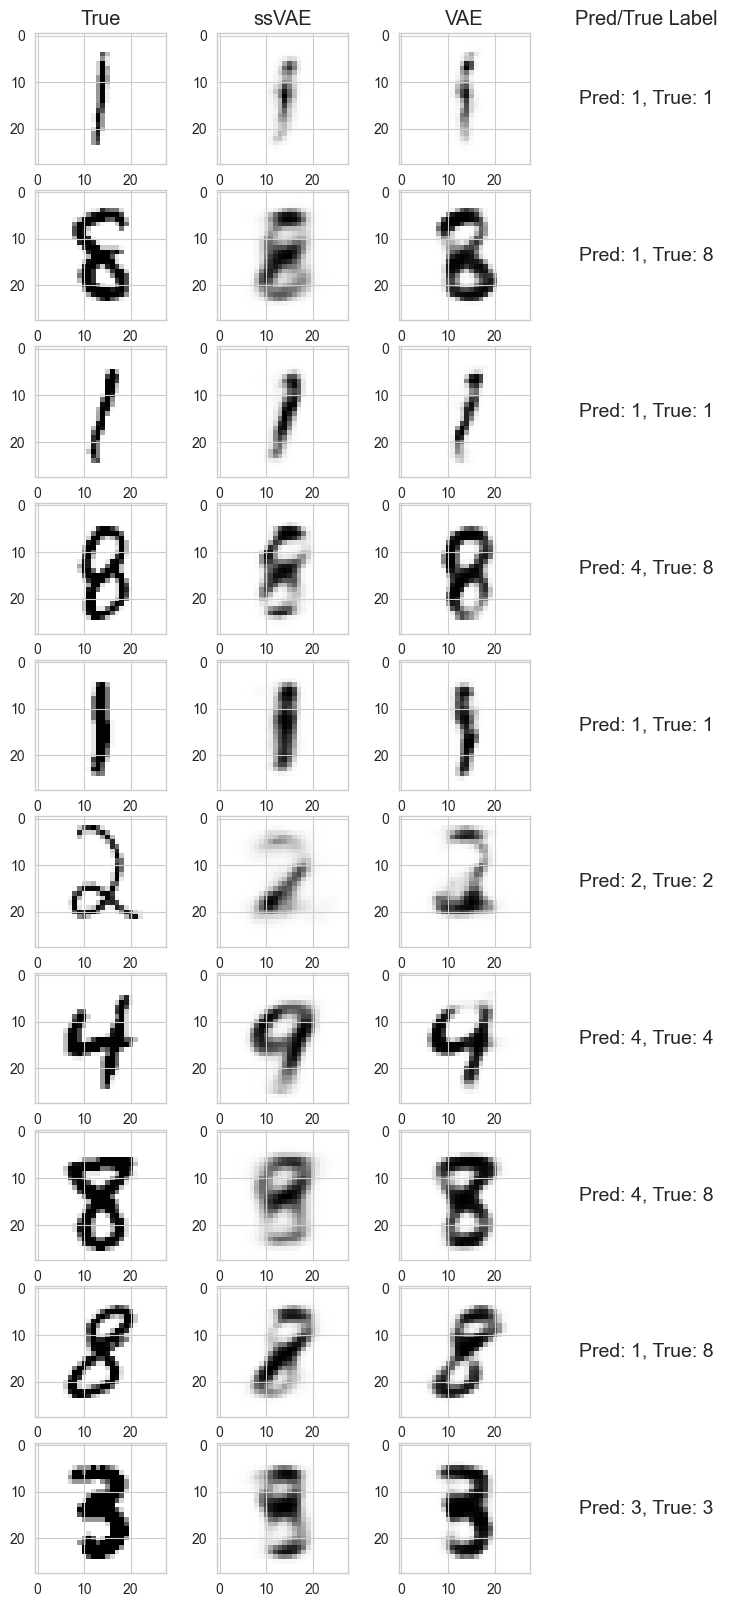

In [69]:
# Obtain both data (x_batch) and labels (y_batch) from the test loader
x_batch, y_batch = next(iter(test_loader))
if use_cuda:
    x_batch = x_batch.cuda()

fig, axs = plt.subplots(10, 4, figsize=(9, 20))

# Pick 10 random images to reconstruct
reco_indices = np.random.randint(0, x_batch.shape[0], 10)
for i in range(10):
    index = reco_indices[i]
    test_img = x_batch[index]

    # Reconstructions from ssVAE and VAE
    reco_img_ssvae = ssvae.reconstruct_img(test_img)
    reco_img_vae = vae.reconstruct_img(test_img)
    
    # Classifier returns a distribution, so extract the predicted label
    pred_label = int(ssvae.classifier(test_img))

    # True label
    true_label = np.argmax(y_batch[index])

    axs[i, 0].imshow(test_img.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
    axs[i, 1].imshow(reco_img_ssvae.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")
    axs[i, 2].imshow(reco_img_vae.reshape(28, 28).detach().cpu().numpy(), cmap="Greys")

    # Fourth subplot: display predicted and true label
    axs[i, 3].axis("off")
    axs[i, 3].text(
        0.5,
        0.5,
        f"Pred: {pred_label}, True: {true_label}",
        fontsize=14,
        ha="center",
        va="center",
    )

axs[0, 0].set_title("True")
axs[0, 1].set_title("ssVAE")
axs[0, 2].set_title("VAE")
axs[0, 3].set_title("Pred/True Label")


T-SNE Plot

# 3. Active Learning - Entropy based sampling method
- From each batch, choose the highest entropy samples to include in the training samples.

In [70]:
def compute_entropy(x):
    z = ssvae.encoder(x)[0]
    alpha = pyro.param("alpha_loc")
    beta = pyro.param("beta_loc")
    logits =   z @ beta + alpha
    return dist.Categorical(logits=logits).entropy()


In [71]:
# This function is to create entropy scores for the unsupervised data
# and then remove the top 10 highest entropy scores
# from the unsupervised data
# This is done to label the most uncertain data points
for i, (x, y) in enumerate(train_loader):
    y = np.argmax(y, axis=1)

    idx_unsup = np.sort(idxs_unsup[i])
    entropy = compute_entropy(x).detach().numpy()
    entropy[~np.isin(np.arange(len(entropy)),idx_unsup)] = -1
    top_10_entropy = entropy.argsort()[-10:]
    idx_unsup_new = [idx for idx in idx_unsup if idx not in top_10_entropy]
    idxs_unsup[i] = idx_unsup_new

In [73]:
pyro.clear_param_store()

# setup the VAE
ssvae = ssVAE(use_cuda=use_cuda, z_dim=50, hidden_dim=400, input_dim=784, binary=True)

# setup the optimizer
adam_args = {"lr": 1.0e-3}
optimizer = Adam(adam_args)

# setup the inference algorithm
elbo = Trace_ELBO()
svi = SVI(ssvae.model, ssvae.guide, optimizer, loss=elbo)

train_elbo = {}
test_elbo = {}
# training loop
num_epochs = 30
fraction = 0.5

for epoch in range(num_epochs):
    # initialize loss accumulator
    epoch_loss = 0.0
    # do a training epoch over each mini-batch x returned
    # by the data loader

    for i, (x, y) in enumerate(train_loader):
        y = np.argmax(y, axis=1)
        idx_unsup_new = idxs_unsup[i]
        y[idx_unsup_new] = -1

        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        epoch_loss += svi.step(x, y, fraction=1-len(idx_unsup_new)/len(y))
            
    if epoch % 5 == 0:
        training_run(svi, epoch, epoch_loss, train_elbo, test_elbo, train_loader, test_loader, y_label=True, use_cuda=use_cuda)


[epoch 000]  average training loss: 234.2035
[epoch 000]  average test loss: 254.6296
[epoch 005]  average training loss: 212.5260
[epoch 005]  average test loss: 215.1497
[epoch 010]  average training loss: 189.7562
[epoch 010]  average test loss: 191.2848
[epoch 015]  average training loss: 167.0367
[epoch 015]  average test loss: 171.2477
[epoch 020]  average training loss: 146.5813
[epoch 020]  average test loss: 150.0315
[epoch 025]  average training loss: 131.8055
[epoch 025]  average test loss: 135.3979


T-SNE Plot

4. Analysis
- Reconstruction Accuracy
- Prediction Accuracy
- 

Things for the report.
1. Purpose, what do we want to do and why? - Marcus
    a. Compare Classification on full dataset vs latent space classification. Otherwise, argue why we think latent space is a wiser choice. Less parameters
    b. PGM (Wednesday)
2. Latent space sequential vs fully implemented. - Maria
3. Showcase that we can do semi-supervised VAE. T-SNE comparison, compare classifier performance. (10% fully supervised, vs 10% semi-supervised) - Te
4. Show how amount of labelled data could be utilized with AL approach, logits vs BALD. - Rui
5. Conclude


Things we are missing,

1. DONE - Trying to reload data with another fraction of Unsupervised and supervised.
2. DONE - Prepare a loss function for supervised and unsupervised. Making batches that have the same proportion of supervised datapoints. 
3. DONE - Reconstruction accuracy
4. DONE - Classifcation Accuracy
5. DONE - Might need more loops - Logits entropy based AL
6. BALD (Bayesian Active Learning by Disagreement)
7. Documentation
8. Consider if should compare the T-SNE during our iterations (VAE, Supervised VAE, ssVAE)
9. Show what the samples we pick look like, and if they are actually just sample with high VAE reconstruction error
10. We might even be able to show sample location of the T-SNE plot.
